# Objective
* 20190208: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Here we use last value to do prediction
* 20190213:
    * Instead of using last value method, we use prophet package to predict

In [3]:
%matplotlib inline

import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime, timedelta
from fbprophet import Prophet
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21                          # Forecast horizon
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set
changepoint_prior_scale_list = [0.05, 0.5, 1, 1.5, 2.5]     # for hyperparameter tuning
fourier_order_list = [None, 2, 4, 6, 8, 10]                 # for hyperparameter tuning
holidays_path = "./data/holidays.csv"                       # csv file containing holidays in the US
window_list = [None, 0, 1, 2]                               # for hyperparameter tuning

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [4]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [5]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_prophet(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Use Prophet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        changepoint_prior_scale : to detect changepoints in time series analysis trajectories
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing holidays you will like to model. 
                                  Must have 'holiday' and 'ds' columns
    Outputs
        A list of predictions
    """
    # Fit prophet model
    if holidays is not None:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
    else:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    if (fourier_order is not None) and (~np.isnan(fourier_order)): # add monthly seasonality
        m.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))

    m.fit(df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=2*H)
    
    # Eliminate weekend from future dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day']<=4]
    
    # Predict
    forecast = m.predict(future) # Note this prediction includes the original dates
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return forecast['yhat'][len(df):len(df)+H]
    
def get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    rmse_mean, mape_mean, mae_mean = get_preds_prophet_parallelized(df, H, changepoint_prior_scale, fourier_order, holidays)

    return rmse_mean, mape_mean, mae_mean, _

def hyperparam_tune_cp(df, H, train_size, val_size, changepoint_prior_scale_list):
    """
    Hyperparameter tuning - changepoint
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        print("changepoint_prior_scale = " + str(changepoint_prior_scale))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Create results dataframe
    results = pd.DataFrame({'changepoint_prior_scale': changepoint_prior_scale_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Return hyperparam corresponding to lowest error metric
    return changepoint_prior_scale_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_fo(df, H, train_size, val_size, fourier_order_list):
    """
    Hyperparameter tuning - fourier order
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        fourier_order_list     : list of fourier_order values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in tqdm_notebook(fourier_order_list):
        print("fourier_order = " + str(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, 0.05, fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_wd(df, H, train_size, val_size, window_list, holidays):
    """
    Hyperparameter tuning - upper and lower windows for holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        window_list            : list of upper and lower window values to try
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window in tqdm_notebook(window_list):
        print("window = " + str(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=None)
        else:
            # Add lower_window and upper_window which extend the holiday out to 
            # [lower_window, upper_window] days around the date
            holidays['lower_window'] = -window
            holidays['upper_window'] = +window
        
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=holidays)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_cp_fo_wd(df, H, train_size, val_size, changepoint_prior_scale_list, 
                             fourier_order_list, window_list, holidays):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
        fourier_order_list          : list of fourier_order values to try
        window_list                 : list of upper and lower window values to try
        holidays                    : dataframe containing holidays you will like to model. 
                                      Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        for fourier_order in tqdm_notebook(fourier_order_list):
            for window in tqdm_notebook(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays=None)
                else:
                    # Add lower_window and upper_window which extend the holiday out to 
                    # [lower_window, upper_window] days around the date
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = +window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                cp_list.append(changepoint_prior_scale)
                fo_list.append(fourier_order)
                wd_list.append(window)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'changepoint_prior_scale': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results



In [6]:
def processInput(i, df, H, changepoint_prior_scale, fourier_order, holidays):
    preds_list = get_preds_prophet(df[i-train_size:i], H, changepoint_prior_scale, fourier_order, holidays)
    
    # Compute error metrics
    rmse = get_rmse(df[i:i+H]['y'], preds_list)
    mape = get_mape(df[i:i+H]['y'], preds_list)
    mae = get_mae(df[i:i+H]['y'], preds_list)
    
    return (rmse, mape, mae)

def get_preds_prophet_parallelized(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, H, changepoint_prior_scale, fourier_order, holidays) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

# Load data

In [7]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

# Get size of dataframe
print("len(df) = " + str(len(df)))

df.head(10)

len(df) = 1509


,date,open,high,low,close,adj_close,volume
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [8]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

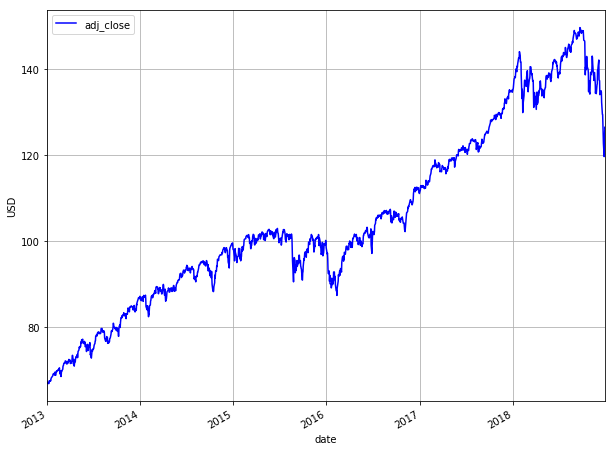

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [10]:
# Prepare dataframe for Prophet
df_prophet = df[['date', 'adj_close']].rename(columns={'date':'ds', 'adj_close':'y'})
df_prophet.head()

,ds,y
0,2013-01-02,66.997757
1,2013-01-03,66.899689
2,2013-01-04,67.238510
3,2013-01-07,67.060173
4,2013-01-08,66.881859


# Predict for a specific H (forecast horizon) and a specific date

In [11]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [12]:
# Fit prophet model
m = Prophet()
m.fit(df_prophet[i-train_val_size:i])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

According to https://facebook.github.io/prophet/docs/non-daily_data.html, since we do not have weekend data, we should eliminate it from the future dataframe before doing predictions.

In [14]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1033,2017-02-06,110.138309,108.125548,112.053311
1034,2017-02-07,110.305862,108.254079,112.538239
1035,2017-02-08,110.460679,108.332158,112.379961
1036,2017-02-09,110.615133,108.461548,112.640433
1037,2017-02-10,110.715946,108.626548,112.793920


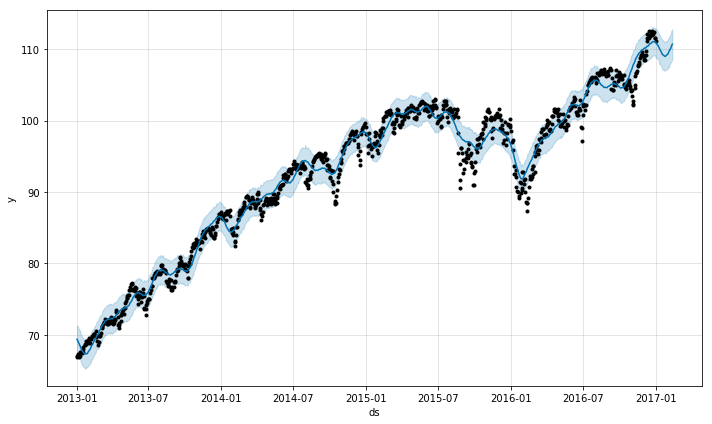

In [15]:
# Plot
m.plot(forecast);

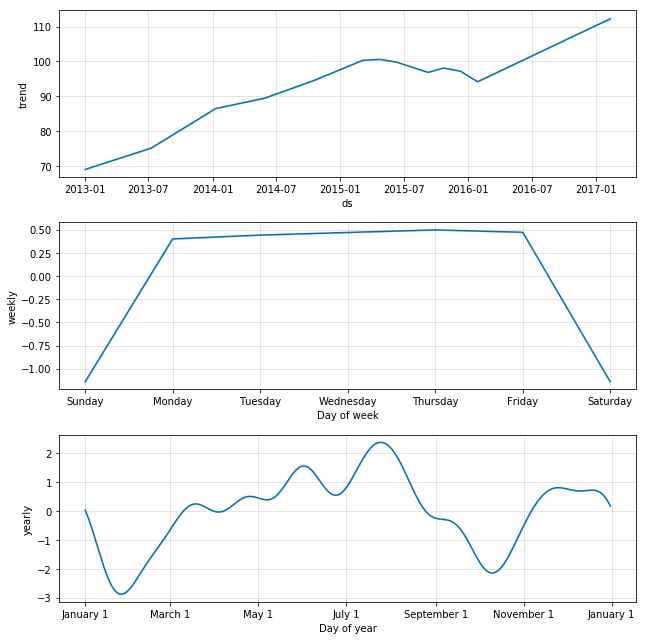

In [16]:
# Plot components
m.plot_components(forecast);

In [17]:
# Compute error metrics
preds_list = forecast['yhat'][i:i+H]
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 3.396327
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 2.871058
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 3.245787


(736269.0, 736388.0)

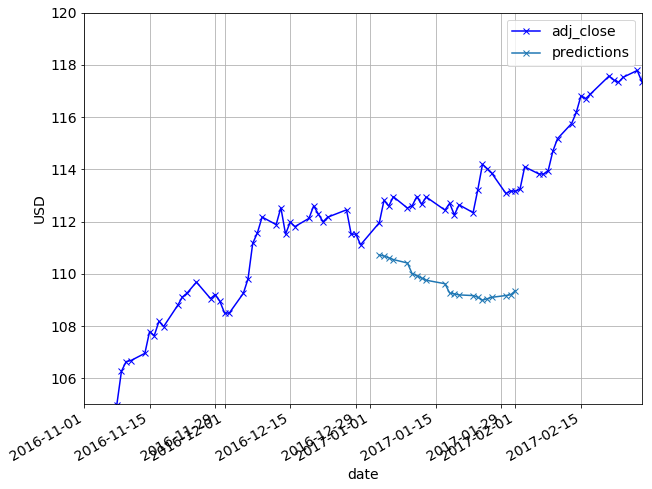

In [18]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint

In [164]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [165]:
# Get optimum hyperparams
tic = time.time()
changepoint_opt, results = hyperparam_tune_cp(df_prophet[i-train_val_size:i], 
                                              H, 
                                              train_size, 
                                              val_size, 
                                              changepoint_prior_scale_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_opt = " + str(changepoint_opt))

results

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


changepoint_prior_scale = 0.05


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

changepoint_prior_scale = 0.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

changepoint_prior_scale = 1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

changepoint_prior_scale = 1.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

changepoint_prior_scale = 2.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Time taken = 7.640918513139089 mins
changepoint_opt = 1


,changepoint_prior_scale,rmse,mape(%),mae
0,0.05,3.467608,3.161614,3.173839
1,0.50,3.411750,2.988456,3.040983
2,1.00,3.407146,2.979764,3.034377
3,1.50,3.431255,2.996462,3.055710
4,2.50,3.638491,3.177134,3.243204


In [166]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, changepoint_prior_scale=changepoint_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.644656
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 0.516127
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 0.582155


(736269.0, 736388.0)

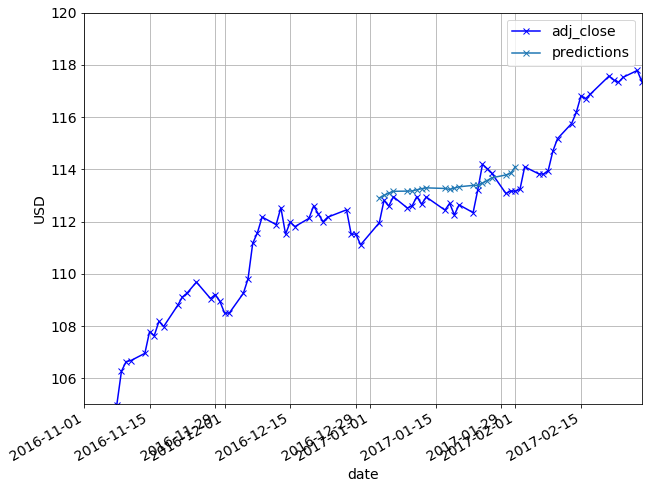

In [167]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

With hyperparameter (changepoint_prior_scale) tuning, the predictions are more accurate

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - monthly seasonality

In [16]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [17]:
# Get optimum hyperparams
tic = time.time()
fourier_order_opt, results = hyperparam_tune_fo(df_prophet[i-train_val_size:i], 
                                                H, 
                                                train_size, 
                                                val_size, 
                                                fourier_order_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("fourier_order_opt = " + str(fourier_order_opt))

results

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


fourier_order = None


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 2


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 3


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 4


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 6


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 7


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 8


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 9


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

fourier_order = 10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru


Time taken = 16.987749270598094 mins
fourier_order_opt = 3


,fourier_order,rmse,mape(%),mae
0,NaN,3.467608,3.161614,3.173839
1,1.0,3.473027,3.163003,3.176272
2,2.0,3.457502,3.152528,3.164549
3,3.0,3.451798,3.141990,3.153149
4,4.0,3.469035,3.162730,3.173878
5,5.0,3.488585,3.182254,3.194354
6,6.0,3.458108,3.150482,3.162692
7,7.0,3.477463,3.166942,3.178952
8,8.0,3.477309,3.167418,3.178861
9,9.0,3.453109,3.145581,3.157322


In [84]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 3.524294
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 2.983402
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 3.372747


(736269.0, 736388.0)

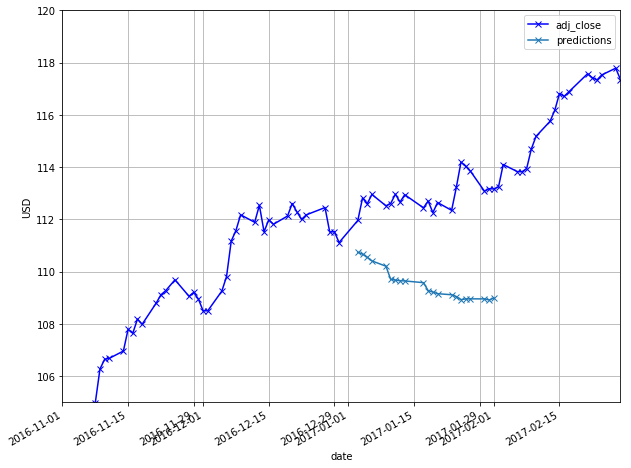

In [85]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - holidays

In [17]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [27]:
# Load holidays file
hols = pd.read_csv(holidays_path, header=None, sep="\t", names=['ds', 'holiday'])

# Convert Date column to datetime
hols.loc[:, 'ds'] = pd.to_datetime(hols['ds'],format='%Y-%m-%d')

# Add lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date
hols['lower_window'] = 0
hols['upper_window'] = 0

hols.head()

,ds,holiday,lower_window,upper_window
0,2013-07-04,Independence Day,0,0
1,2013-09-02,Labor Day,0,0
2,2013-10-14,Columbus Day,0,0
3,2013-11-11,Veterans Day,0,0
4,2013-11-28,Thanksgiving Day,0,0


In [20]:
# Get optimum hyperparams
tic = time.time()
window_opt, results = hyperparam_tune_wd(df_prophet[i-train_val_size:i], 
                                         H, 
                                         train_size, 
                                         val_size, 
                                         window_list,
                                         hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("window_opt = " + str(window_opt))

results

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


window = None


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

window = 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

window = 1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

window = 2


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

window = 3


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru


Time taken = 9.013871232668558 mins
window_opt = None


,window,rmse,mape(%),mae
0,NaN,3.467608,3.161614,3.173839
1,0.0,3.473777,3.165241,3.177676
2,1.0,3.477157,3.156044,3.167002
3,2.0,3.512874,3.185587,3.195946
4,3.0,3.542850,3.195022,3.208332


In [81]:
# Get predictions using tuned hyperparams
if window_opt is None:
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 3.179621
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 2.683207
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 3.033540


(736269.0, 736388.0)

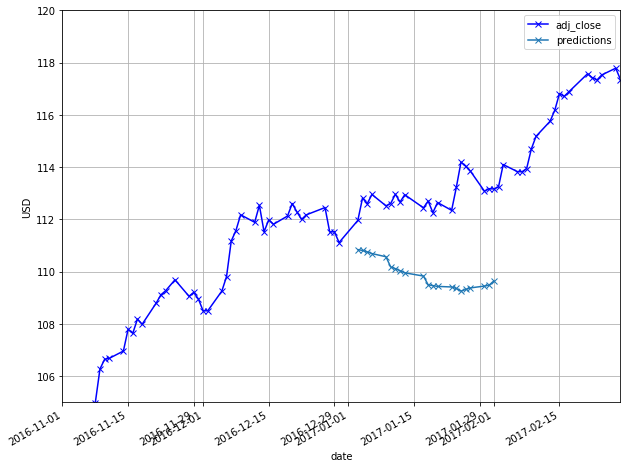

In [82]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint, monthly seasonality, holidays

In [28]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-03 00:00:00, with forecast horizon H = 21


In [29]:
# Get optimum hyperparams
tic = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
    hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                             H, 
                             train_size, 
                             val_size, 
                             changepoint_prior_scale_list,
                             fourier_order_list,
                             window_list,
                             hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_prior_scale_opt = " + str(changepoint_prior_scale_opt))
print("fourier_order_opt = " + str(fourier_order_opt))
print("window_opt = " + str(window_opt))
results


Time taken = 112.76676173210144 mins
changepoint_prior_scale_opt = 2.5
fourier_order_opt = 10.0
window_opt = nan


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
0,0.05,NaN,NaN,3.467608,3.161614,3.173839
1,0.05,NaN,0.0,3.473777,3.165241,3.177676
2,0.05,NaN,1.0,3.477157,3.156044,3.167002
3,0.05,NaN,2.0,3.512874,3.185587,3.195946
4,0.05,2.0,NaN,3.457502,3.152528,3.164549
5,0.05,2.0,0.0,3.465889,3.158415,3.170350
6,0.05,2.0,1.0,3.496011,3.180204,3.191632
7,0.05,2.0,2.0,3.529013,3.198917,3.210664
8,0.05,4.0,NaN,3.469035,3.162730,3.173878
9,0.05,4.0,0.0,3.475127,3.162336,3.173882


In [30]:
# Print the tail of the results df
results.tail()

,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
115,2.5,8.0,2.0,3.503154,3.068466,3.123733
116,2.5,10.0,NaN,3.285985,2.854324,2.904182
117,2.5,10.0,0.0,3.389648,2.943739,3.000540
118,2.5,10.0,1.0,3.455438,3.024427,3.076345
119,2.5,10.0,2.0,3.345294,2.923751,2.972843


In [31]:
# Get predictions using tuned hyperparams
if (window_opt is None) or (np.isnan(window_opt)):
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.549689
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 0.413399
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 0.466406


(736269.0, 736388.0)

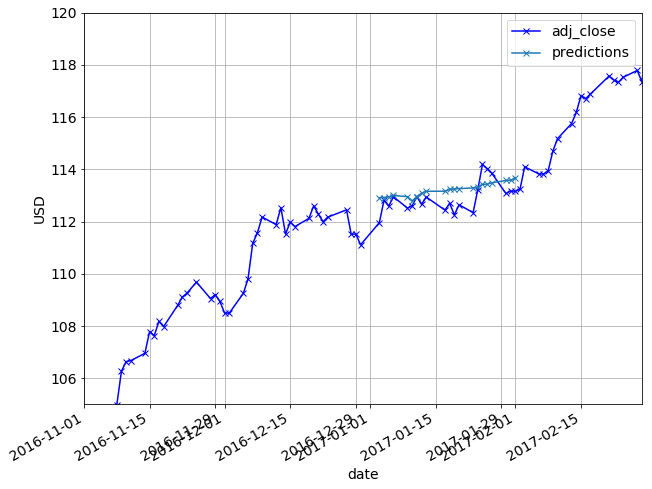

In [32]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [28]:
changepoint_prior_scale_opt = 2.5
fourier_order_opt = 10
window_opt = None

In [29]:
# Predict using Prophet, and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df_prophet['ds'][i]))
    
#     changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
#         hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
#                                  H, 
#                                  train_size, 
#                                  val_size, 
#                                  changepoint_prior_scale_list,
#                                  fourier_order_list,
#                                  window_list,
#                                  hols)
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df_prophet[i:i+H]['y'], preds_list))
    mape.append(get_mape(df_prophet[i:i+H]['y'], preds_list))
    mae.append(get_mae(df_prophet[i:i+H]['y'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1008, date 2017-01-03 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1050, date 2017-03-06 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1092, date 2017-05-04 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1134, date 2017-07-05 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1176, date 2017-09-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1218, date 2017-11-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1260, date 2018-01-03 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1302, date 2018-03-06 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1344, date 2018-05-04 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1386, date 2018-07-05 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1428, date 2018-09-04 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicting on day 1470, date 2018-11-01 00:00:00
Altogether we made 12 forecasts, each of length 21 days


In [30]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 2.732487
For forecast horizon 21, the mean MAPE is 1.869825
For forecast horizon 21, the mean MAE is 2.491599


In [34]:
results_final_no_tune = pd.DataFrame({'day': i_list,
                                      'changepoint_opt': [changepoint_prior_scale_opt]*len(i_list),
                                      'fourier_order_opt': [fourier_order_opt]*len(i_list),
                                      'window_opt': [window_opt]*len(i_list),
                                      'rmse': rmse,
                                      'mape': mape,
                                      'mae': mae})
results_final_no_tune

,day,changepoint_opt,fourier_order_opt,window_opt,rmse,mape,mae
0,1008,2.5,10,None,0.549689,0.413399,0.466406
1,1050,2.5,10,None,3.380764,2.741116,3.208425
2,1092,2.5,10,None,1.124702,0.841112,1.004871
3,1134,2.5,10,None,0.683860,0.487463,0.597872
4,1176,2.5,10,None,1.651469,1.161445,1.457057
5,1218,2.5,10,None,4.644254,3.418298,4.451833
6,1260,2.5,10,None,5.446702,3.458844,4.893595
7,1302,2.5,10,None,2.541313,1.606686,2.201834
8,1344,2.5,10,None,4.795203,3.360170,4.648887
9,1386,2.5,10,None,1.030396,0.570690,0.816927


Text(0, 0.5, 'USD')

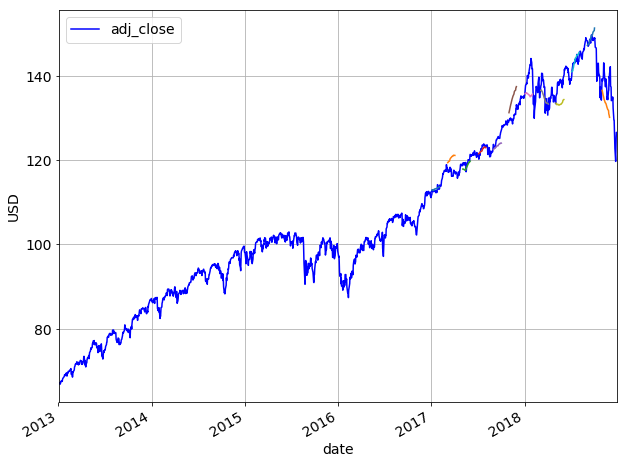

In [31]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")

(736330.0, 737059.0)

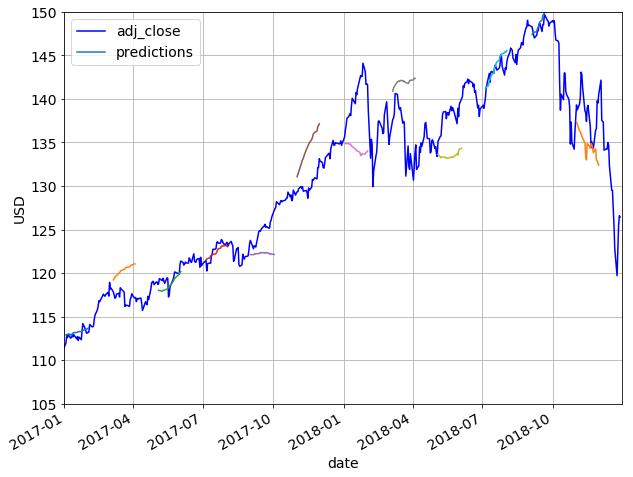

In [22]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

Using a static model achieves bad results. The model should be re-trained for every forecast.

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [18]:
i_list = [train_val_size+294, train_val_size+378, train_val_size+462]
for i in i_list:
    print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}

    tic = time.time()
    
    changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
        hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                                 H, 
                                 train_size, 
                                 val_size, 
                                 changepoint_prior_scale_list,
                                 fourier_order_list,
                                 window_list,
                                 hols)
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Compute error metrics
    rmse = get_rmse(df_prophet[i:i+H]['y'], preds_list)
    mape = get_mape(df_prophet[i:i+H]['y'], preds_list)
    mae = get_mae(df_prophet[i:i+H]['y'], preds_list)

    # Put results into pickle
    pickle.dump(preds_list, open("./data/preds_list_" + str(i) + ".pickle", "wb"))
    pickle.dump(rmse, open("./data/rmse_" + str(i) + ".pickle", "wb"))
    pickle.dump(mape, open("./data/mape_" + str(i) + ".pickle", "wb"))
    pickle.dump(mae, open("./data/mae_" + str(i) + ".pickle", "wb"))
    pickle.dump(changepoint_prior_scale_opt, open("./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(fourier_order_opt, open("./data/fourier_order_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(window_opt, open("./data/window_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(results, open("./data/results_" + str(i) + ".pickle", "wb"))
    
    toc = time.time()
    print("Time taken = " + str((toc-tic)/60.0))

Predicting on day 1302, date 2018-03-06 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 99.4053551475207
Predicting on day 1386, date 2018-07-05 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 96.90871193408967
Predicting on day 1470, date 2018-11-01 00:00:00, with forecast horizon H = 21


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Time taken = 95.0793583671252


In [23]:
# Load pickle file
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
# i_list = [train_val_size, train_val_size+42, train_val_size+84, train_val_size+126, train_val_size+84*2, 
#           train_val_size+210, train_val_size+84*3, train_val_size+84*4, train_val_size+84*5]
preds_dict = {}
rmse, mape, mae, changepoint_prior_scale_opt, fourier_order_opt, window_opt = [], [], [], [], [], []

for i in i_list:
    preds_dict[i] = pickle.load(open( "./data/preds_list_" + str(i) + ".pickle", "rb"))
    rmse.append(pickle.load(open( "./data/rmse_" + str(i) + ".pickle", "rb")))
    mape.append(pickle.load(open( "./data/mape_" + str(i) + ".pickle", "rb")))
    mae.append(pickle.load(open( "./data/mae_" + str(i) + ".pickle", "rb")))
    changepoint_prior_scale_opt.append(pickle.load(open( "./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "rb")))
    fourier_order_opt.append(pickle.load(open( "./data/fourier_order_opt_" + str(i) + ".pickle", "rb")))
    window_opt.append(pickle.load(open( "./data/window_opt_" + str(i) + ".pickle", "rb")))

In [24]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 3.163655
For forecast horizon 21, the mean MAPE is 2.145439
For forecast horizon 21, the mean MAE is 2.859784


In [25]:
results_final = pd.DataFrame({'day': i_list,
                              'changepoint_opt': changepoint_prior_scale_opt,
                              'fourier_order_opt': fourier_order_opt,
                              'window_opt': window_opt,
                              'rmse': rmse,
                              'mape': mape,
                              'mae': mae})
results_final

,day,changepoint_opt,fourier_order_opt,window_opt,rmse,mape,mae
0,1008,2.50,10.0,NaN,0.549689,0.413399,0.466406
1,1050,0.50,NaN,NaN,3.221916,2.621324,3.068330
2,1092,0.50,NaN,NaN,0.919853,0.673048,0.803092
3,1134,0.50,10.0,0.0,0.649267,0.452010,0.554066
4,1176,0.05,NaN,0.0,2.863377,2.099864,2.632234
5,1218,0.50,10.0,0.0,4.389950,3.221738,4.195792
6,1260,0.50,10.0,NaN,6.767098,4.411612,6.235123
7,1302,0.05,4.0,0.0,6.708947,4.349691,5.838674
8,1344,0.50,8.0,1.0,4.739977,3.314702,4.586408
9,1386,1.50,NaN,NaN,1.092350,0.589348,0.843652


(736330.0, 737059.0)

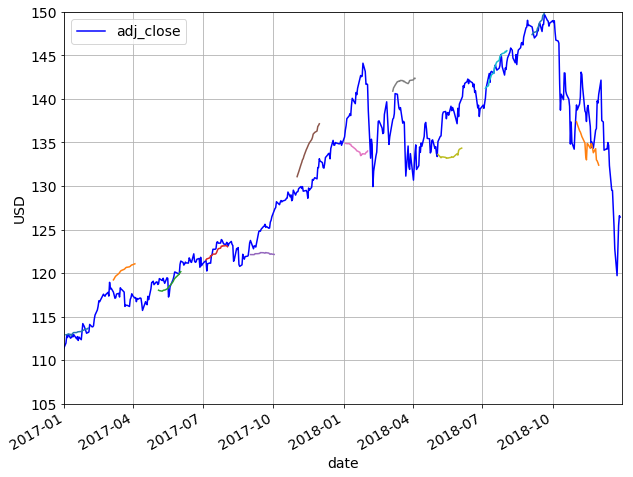

In [26]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Findings


In [39]:
# Consolidate results from hyperparameter tuning
pd.set_option('display.max_colwidth', -1)  # or 199
results = pd.DataFrame({'Method': ['Last Value', 
                                   'Prophet - no hyperparameter tuning', 
                                   'Prophet tuning changepoint', 
                                   'Prophet tuning fourier order', 
                                   'Prophet tuning window size', 
                                   'Prophet tuning changepoint, fourier order, and window size'],
                        'RMSE'    : [2.56, 3.40, 0.64, 3.52, 3.40, 0.55],
                        'MAPE(%)' : [1.65, 2.87, 0.52, 2.98, 2.87, 0.41],
                        'MAE'     : [2.19, 3.25, 0.58, 3.37, 3.25, 0.47]                       
                       })
results

,Method,RMSE,MAPE(%),MAE
0,Last Value,2.56,1.65,2.19
1,Prophet - no hyperparameter tuning,3.40,2.87,3.25
2,Prophet tuning changepoint,0.64,0.52,0.58
3,Prophet tuning fourier order,3.52,2.98,3.37
4,Prophet tuning window size,3.40,2.87,3.25
5,"Prophet tuning changepoint, fourier order, and window size",0.55,0.41,0.47
